In [1]:
### EEGNet Training Notebook

# --- 1. Import Dependencies ---
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from model import EEGNet, EEGDataset, create_dataloaders, train_model, plot_metrics, save_training_stats
from explore import apply_bandpass_filter
from load_data import get_dataset


# --- 2. Load Raw EEG Data ---
train_df = get_dataset("data/SMNI_CMI_TRAIN/Train/")
test_df = get_dataset("data/SMNI_CMI_TEST/Test/")
df = pd.concat([train_df, test_df], ignore_index=True)


# --- 3. Apply Bandpass Filter ---
filtered_df = df.groupby(['name', 'trial number', 'sensor position']) \
               .apply(apply_bandpass_filter) \
               .reset_index(drop=True)

dataset loaded from tmp/dea5a0ab2c.pickle
dataset loaded from tmp/0d05880708.pickle


In [2]:
# --- 4. Extract Real EEG Sequences ---
def extract_eeg_sequences(df: pd.DataFrame, group_label: int):
    eeg_segments = []
    labels = []
    grouped = df.groupby(['name', 'trial number'])

    for (name, trial), group in grouped:
        pivot = group.pivot_table(
            index='sensor position',
            columns='time',
            values='filtered_sensor_value',
            aggfunc='mean'
        )

        if pivot.shape != (64, 256):  # ensure fixed shape
            continue

        eeg_segments.append(pivot.values)
        labels.append(group_label)

    return np.stack(eeg_segments), np.array(labels)


alcohol_df = filtered_df[filtered_df['subject identifier'] == 'a']
control_df = filtered_df[filtered_df['subject identifier'] == 'c']

X_a, y_a = extract_eeg_sequences(alcohol_df, group_label=0)
X_c, y_c = extract_eeg_sequences(control_df, group_label=1)

X_full = np.concatenate([X_a, X_c], axis=0)
y_full = np.concatenate([y_a, y_c], axis=0)

In [3]:

# --- 5. Create DataLoaders ---
train_loader, val_loader = create_dataloaders(X_full, y_full, batch_size=32)


# --- 6. Initialize and Train Model ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = EEGNet(num_channels=64, num_time_points=256, num_classes=2)
print("Model Summary:")
print(model)

Model Summary:
EEGNet(
  (conv1): Conv2d(1, 8, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32), bias=False)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (depthwise_conv): Conv2d(8, 16, kernel_size=(64, 1), stride=(1, 1), groups=8, bias=False)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation1): ELU(alpha=1.0)
  (avgpool1): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
  (dropout1): Dropout(p=0.5, inplace=False)
  (separable_conv): Sequential(
    (0): Conv2d(16, 16, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), bias=False)
    (1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation2): ELU(alpha=1.0)
  (avgpool2): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
  (dropout2): Dropout(p=0.5, inplace=False)
  (classifier): Linear(in_features=128, out

In [4]:
sample_X, _ = next(iter(train_loader))
print(sample_X.shape)  # should be (B, 1, 64, 128)


torch.Size([32, 1, 64, 256])


Epoch 1/20 | Train Loss: 0.6635 | Val Loss: 0.5823 | Val Acc: 0.7189
Epoch 2/20 | Train Loss: 0.5441 | Val Loss: 0.4784 | Val Acc: 0.7946
Epoch 3/20 | Train Loss: 0.4862 | Val Loss: 0.3969 | Val Acc: 0.8649
Epoch 4/20 | Train Loss: 0.4202 | Val Loss: 0.3261 | Val Acc: 0.9135
Epoch 5/20 | Train Loss: 0.3735 | Val Loss: 0.2612 | Val Acc: 0.9514
Epoch 6/20 | Train Loss: 0.3250 | Val Loss: 0.2205 | Val Acc: 0.9351
Epoch 7/20 | Train Loss: 0.2708 | Val Loss: 0.1770 | Val Acc: 0.9514
Epoch 8/20 | Train Loss: 0.2341 | Val Loss: 0.1353 | Val Acc: 0.9676
Epoch 9/20 | Train Loss: 0.2092 | Val Loss: 0.1076 | Val Acc: 0.9730
Epoch 10/20 | Train Loss: 0.2324 | Val Loss: 0.0845 | Val Acc: 0.9838
Epoch 11/20 | Train Loss: 0.1939 | Val Loss: 0.0829 | Val Acc: 0.9838
Epoch 12/20 | Train Loss: 0.1294 | Val Loss: 0.0714 | Val Acc: 0.9784
Epoch 13/20 | Train Loss: 0.1408 | Val Loss: 0.0415 | Val Acc: 0.9946
Epoch 14/20 | Train Loss: 0.1579 | Val Loss: 0.0499 | Val Acc: 0.9838
Epoch 15/20 | Train Loss: 0.1

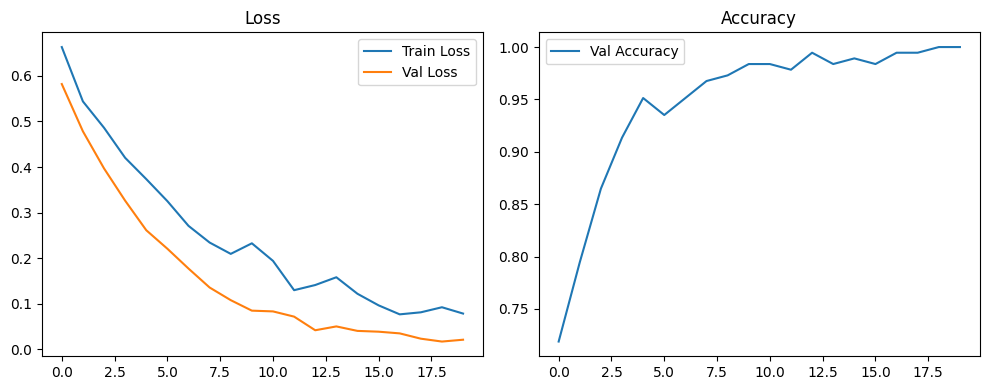

In [5]:
# --- 8. Train the Model ---
stats = train_model(model, train_loader, val_loader, epochs=20, lr=1e-3, device=device)
torch.save(model.state_dict(), "models/signal_only_model.pt")
# --- 9. Plot and Save Metrics ---
plot_metrics(stats)
save_training_stats(stats, "training_stats.csv")

In [6]:
from torch.utils.data import DataLoader


def evaluate_on_full_data(model, X, y, batch_size=32, device='cpu'):
    model.eval()
    dataset = EEGDataset(X, y)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    correct = 0

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            pred = output.argmax(dim=1)
            correct += pred.eq(y_batch).sum().item()

    return correct / len(dataset)

acc = evaluate_on_full_data(model, X_full, y_full, device=device)
print(f"Accuracy on all data: {acc:.4f}")



Accuracy on all data: 1.0000


dataset loaded from tmp/dea5a0ab2c.pickle
dataset loaded from tmp/0d05880708.pickle
Epoch 1 | Train Loss: 0.8541 | Val Loss: 0.6341 | Val Acc: 0.6324
Epoch 2 | Train Loss: 0.6241 | Val Loss: 0.5042 | Val Acc: 0.7351
Epoch 3 | Train Loss: 0.4868 | Val Loss: 0.3713 | Val Acc: 0.8162
Epoch 4 | Train Loss: 0.3790 | Val Loss: 0.2879 | Val Acc: 0.8703
Epoch 5 | Train Loss: 0.3254 | Val Loss: 0.2504 | Val Acc: 0.8757
Epoch 6 | Train Loss: 0.2929 | Val Loss: 0.1731 | Val Acc: 0.9459
Epoch 7 | Train Loss: 0.2235 | Val Loss: 0.1355 | Val Acc: 0.9243
Epoch 8 | Train Loss: 0.2003 | Val Loss: 0.1119 | Val Acc: 0.9676
Epoch 9 | Train Loss: 0.1734 | Val Loss: 0.0751 | Val Acc: 0.9838
Epoch 10 | Train Loss: 0.1935 | Val Loss: 0.0581 | Val Acc: 0.9892
Epoch 11 | Train Loss: 0.1661 | Val Loss: 0.0778 | Val Acc: 0.9892
Epoch 12 | Train Loss: 0.1150 | Val Loss: 0.0493 | Val Acc: 0.9892
Epoch 13 | Train Loss: 0.1048 | Val Loss: 0.0422 | Val Acc: 0.9892
Epoch 14 | Train Loss: 0.1035 | Val Loss: 0.0495 | Val

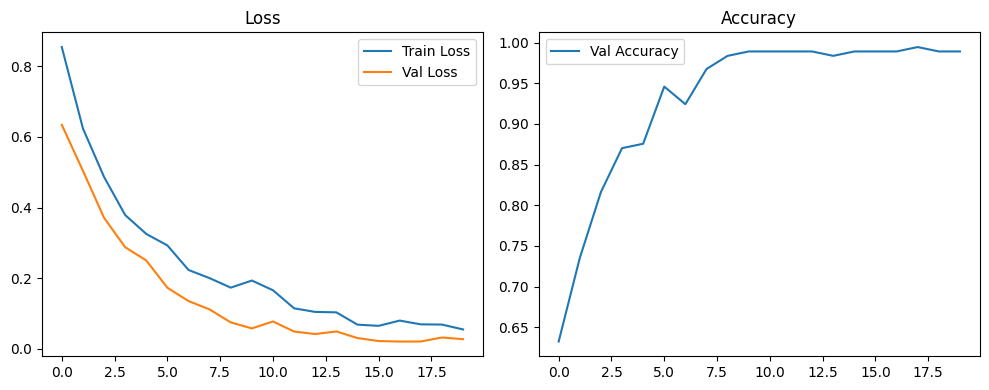

In [7]:
# EEGNet Training and Comparison Notebook

# --- 1. Imports ---
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from model import EEGNet, train_model, plot_metrics, save_training_stats
from feature_extraction import extract_all_features_per_trial
from explore import apply_bandpass_filter
from load_data import get_dataset


# --- 2. Load and Filter EEG Data ---
train_df = get_dataset("data/SMNI_CMI_TRAIN/Train/")
test_df = get_dataset("data/SMNI_CMI_TEST/Test/")
df = pd.concat([train_df, test_df], ignore_index=True)

filtered_df = df.groupby(['name', 'trial number', 'sensor position']) \
               .apply(apply_bandpass_filter) \
               .reset_index(drop=True)


# --- 3. Extract Raw EEG Sequences ---
def extract_eeg_sequences(df: pd.DataFrame, group_label: int):
    eeg_segments = []
    labels = []
    grouped = df.groupby(['name', 'trial number'])

    for (name, trial), group in grouped:
        pivot = group.pivot_table(index='sensor position', columns='time', values='filtered_sensor_value', aggfunc='mean')
        if pivot.shape != (64, 256):
            continue
        eeg_segments.append(pivot.values)
        labels.append(group_label)

    return np.stack(eeg_segments), np.array(labels)

alcohol_df = filtered_df[filtered_df['subject identifier'] == 'a']
control_df = filtered_df[filtered_df['subject identifier'] == 'c']
X_a, y_a = extract_eeg_sequences(alcohol_df, 0)
X_c, y_c = extract_eeg_sequences(control_df, 1)
X_seq = np.concatenate([X_a, X_c], axis=0)
y_seq = np.concatenate([y_a, y_c], axis=0)


# --- 4. Extract Features ---
features_a = extract_all_features_per_trial(alcohol_df, 'a', 'filtered_sensor_value')
features_c = extract_all_features_per_trial(control_df, 'c', 'filtered_sensor_value')
features = pd.concat([features_a, features_c], ignore_index=True)
features.dropna(inplace=True)
features_X = features.drop(columns=['subject', 'trial', 'sensor', 'group']).values
features_y = LabelEncoder().fit_transform(features['group'].values)


# --- 5. Match Feature and EEG Entries (by index reset) ---
min_len = min(len(X_seq), len(features_X))
X_seq, y_seq = X_seq[:min_len], y_seq[:min_len]
features_X, features_y = features_X[:min_len], features_y[:min_len]


# --- 6. Define Dual-Input Dataset ---
class EEGWithFeaturesDataset(Dataset):
    def __init__(self, X_eeg, X_feat, y):
        self.X_eeg = torch.tensor(X_eeg, dtype=torch.float32).unsqueeze(1)
        self.X_feat = torch.tensor(X_feat, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X_eeg)

    def __getitem__(self, idx):
        return self.X_eeg[idx], self.X_feat[idx], self.y[idx]


# --- 7. Define Fused Model ---
class EEGNetWithFeatures(torch.nn.Module):
    def __init__(self, num_channels=64, num_time_points=256, num_features=17, num_classes=2):
        super().__init__()
        self.eegnet = EEGNet(num_channels, num_time_points, num_classes=32)
        self.feat_net = torch.nn.Sequential(
            torch.nn.Linear(num_features, 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(64, 32)
        )
        self.classifier = torch.nn.Linear(64, num_classes)

    def forward(self, eeg, feat):
        eeg_out = self.eegnet(eeg)
        feat_out = self.feat_net(feat)
        fused = torch.cat([eeg_out, feat_out], dim=1)
        return torch.nn.functional.log_softmax(self.classifier(fused), dim=1)


# --- 8. Create DataLoaders ---
def create_dataloader(X1, X2, y, batch_size=32, split=0.2):
    X1_train, X1_val, X2_train, X2_val, y_train, y_val = train_test_split(X1, X2, y, test_size=split, stratify=y)
    train = EEGWithFeaturesDataset(X1_train, X2_train, y_train)
    val = EEGWithFeaturesDataset(X1_val, X2_val, y_val)
    return DataLoader(train, batch_size=batch_size, shuffle=True), DataLoader(val, batch_size=batch_size)


# --- 9. Train Fused Model ---
train_loader, val_loader = create_dataloader(X_seq, features_X, y_seq)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = EEGNetWithFeatures(num_channels=64, num_time_points=256, num_features=features_X.shape[1], num_classes=2)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.NLLLoss()

stats = {"train_loss": [], "val_loss": [], "val_acc": []}

for epoch in range(20):
    model.train()
    total_loss = 0
    for eeg, feat, y in train_loader:
        eeg, feat, y = eeg.to(device), feat.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(eeg, feat)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    stats["train_loss"].append(total_loss / len(train_loader))

    model.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for eeg, feat, y in val_loader:
            eeg, feat, y = eeg.to(device), feat.to(device), y.to(device)
            out = model(eeg, feat)
            loss = criterion(out, y)
            val_loss += loss.item()
            correct += (out.argmax(1) == y).sum().item()
    stats["val_loss"].append(val_loss / len(val_loader))
    stats["val_acc"].append(correct / len(val_loader.dataset))
    print(f"Epoch {epoch+1} | Train Loss: {stats['train_loss'][-1]:.4f} | Val Loss: {stats['val_loss'][-1]:.4f} | Val Acc: {stats['val_acc'][-1]:.4f}")

# --- 10. Save ---
import os

# --- 10. Save ---
os.makedirs("models", exist_ok=True)
torch.save(model.state_dict(), "models/fused_model.pt")
save_training_stats(stats, "training_stats_fused.csv")
plot_metrics(stats)

Epoch 1/20 | Train Loss: 0.6487 | Val Loss: 0.6321 | Val Acc: 0.6502
Epoch 2/20 | Train Loss: 0.6312 | Val Loss: 0.6257 | Val Acc: 0.6540
Epoch 3/20 | Train Loss: 0.6256 | Val Loss: 0.6231 | Val Acc: 0.6560
Epoch 4/20 | Train Loss: 0.6226 | Val Loss: 0.6210 | Val Acc: 0.6589
Epoch 5/20 | Train Loss: 0.6203 | Val Loss: 0.6166 | Val Acc: 0.6600
Epoch 6/20 | Train Loss: 0.6182 | Val Loss: 0.6160 | Val Acc: 0.6589
Epoch 7/20 | Train Loss: 0.6163 | Val Loss: 0.6142 | Val Acc: 0.6647
Epoch 8/20 | Train Loss: 0.6149 | Val Loss: 0.6158 | Val Acc: 0.6648
Epoch 9/20 | Train Loss: 0.6149 | Val Loss: 0.6121 | Val Acc: 0.6626
Epoch 10/20 | Train Loss: 0.6115 | Val Loss: 0.6110 | Val Acc: 0.6660
Epoch 11/20 | Train Loss: 0.6123 | Val Loss: 0.6124 | Val Acc: 0.6642
Epoch 12/20 | Train Loss: 0.6109 | Val Loss: 0.6130 | Val Acc: 0.6633
Epoch 13/20 | Train Loss: 0.6096 | Val Loss: 0.6105 | Val Acc: 0.6673
Epoch 14/20 | Train Loss: 0.6094 | Val Loss: 0.6086 | Val Acc: 0.6681
Epoch 15/20 | Train Loss: 0.6

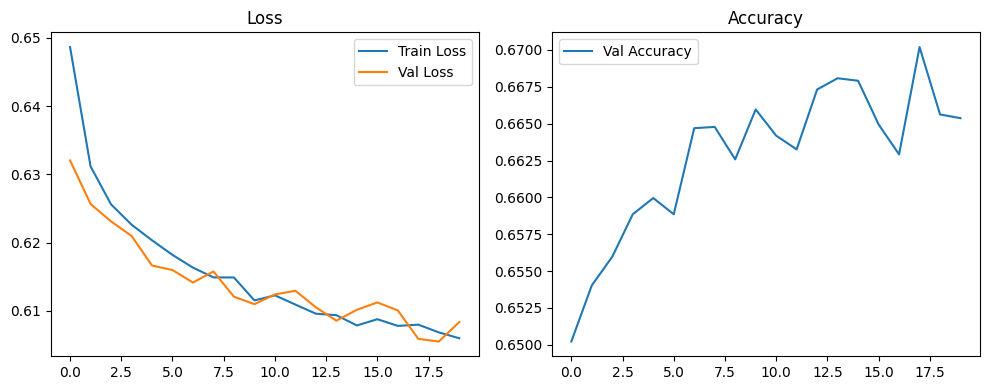

In [8]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from model import plot_metrics, save_training_stats

# === Load Features ===
df_a = pd.read_csv("data/alcoholic_features.csv")
df_c = pd.read_csv("data/control_features.csv")
df = pd.concat([df_a, df_c], ignore_index=True)
df.dropna(inplace=True)

X = df.drop(columns=["subject", "trial", "sensor", "group"]).values
y = LabelEncoder().fit_transform(df["group"].values)

# === Dataset & DataLoader ===
class FeatureDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def create_dataloaders(X, y, batch_size=32, val_split=0.2):
    X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=val_split)
    train_ds = FeatureDataset(X_train, y_train)
    val_ds = FeatureDataset(X_val, y_val)
    return (
        DataLoader(train_ds, batch_size=batch_size, shuffle=True),
        DataLoader(val_ds, batch_size=batch_size, shuffle=False),
    )

train_loader, val_loader = create_dataloaders(X, y)

# === Model ===
class FeatureClassifier(nn.Module):
    def __init__(self, input_dim, num_classes=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return torch.nn.functional.log_softmax(self.net(x), dim=1)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = FeatureClassifier(X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.NLLLoss()

# === Training Loop ===
stats = {"train_loss": [], "val_loss": [], "val_acc": []}
epochs = 20

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        out = model(X_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    stats["train_loss"].append(total_loss / len(train_loader))

    model.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            out = model(X_batch)
            val_loss += criterion(out, y_batch).item()
            correct += (out.argmax(dim=1) == y_batch).sum().item()

    stats["val_loss"].append(val_loss / len(val_loader))
    stats["val_acc"].append(correct / len(val_loader.dataset))

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {stats['train_loss'][-1]:.4f} | Val Loss: {stats['val_loss'][-1]:.4f} | Val Acc: {stats['val_acc'][-1]:.4f}")

# === Save Results ===
torch.save(model.state_dict(), "models/features_only_model.pt")
save_training_stats(stats, "training_stats_features_only.csv")
plot_metrics(stats)


In [19]:
from model import EEGNet, EEGDataset  # your model module
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

def compare_models(models_and_datasets, labels, device='cpu'):
    results = []

    for (model_path, dataset, is_fused), label in zip(models_and_datasets, labels):
        if is_fused:
            model = EEGNetWithFeatures(
                num_channels=64,
                num_time_points=256,
                num_features=dataset.X_feat.shape[1],
                num_classes=2
            )
        elif isinstance(dataset, EEGDataset):
            model = EEGNet(num_channels=64, num_time_points=256, num_classes=2)
        elif isinstance(dataset, FeatureDataset):
            model = FeatureClassifier(input_dim=dataset.X.shape[1], num_classes=2)
        else:
            raise ValueError("Unknown dataset type")

        model.load_state_dict(torch.load(model_path, map_location=device))
        model.to(device)
        model.eval()

        loader = DataLoader(dataset, batch_size=32, shuffle=False)
        y_true, y_pred, y_proba = [], [], []

        with torch.no_grad():
            for batch in loader:
                if is_fused:
                    eeg, feat, y = batch
                    eeg, feat = eeg.to(device), feat.to(device)
                    out = model(eeg, feat)
                elif isinstance(dataset, EEGDataset):
                    eeg, y = batch
                    eeg = eeg.to(device)
                    out = model(eeg)
                elif isinstance(dataset, FeatureDataset):
                    feat, y = batch
                    feat = feat.to(device)
                    out = model(feat)

                y_true.extend(y.cpu().numpy())
                y_pred.extend(out.argmax(dim=1).cpu().numpy())
                y_proba.extend(torch.exp(out)[:, 1].cpu().numpy())

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        y_proba = np.array(y_proba)

        auc = roc_auc_score(y_true, y_proba) if len(np.unique(y_true)) > 1 else float('nan')

        results.append({
            "label": label,
            "y_true": y_true,
            "y_pred": y_pred,
            "y_proba": y_proba,
            "acc": accuracy_score(y_true, y_pred),
            "auc": auc,
            "conf": confusion_matrix(y_true, y_pred)
        })

    return results

def plot_comparison(results):
    plt.figure(figsize=(15, 5))

    # Accuracy & AUC Bar Plot
    plt.subplot(1, 3, 1)
    labels = [r["label"] for r in results]
    accs = [r["acc"] for r in results]
    aucs = [r["auc"] if not np.isnan(r["auc"]) else 0 for r in results]

    x = np.arange(len(labels))
    plt.bar(x - 0.15, accs, width=0.3, label="Accuracy")
    plt.bar(x + 0.15, aucs, width=0.3, label="AUC")
    plt.xticks(x, labels)
    plt.ylim(0, 1)
    plt.title("Model Performance")
    plt.legend()

    # Confusion Matrices
    for i, r in enumerate(results):
        plt.subplot(1, 3, 2 + (i % 2))
        cm = r["conf"]
        plt.imshow(cm, cmap="Blues")
        plt.title(f"{r['label']} Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        for (j, k), val in np.ndenumerate(cm):
            plt.text(k, j, int(val), ha='center', va='center', color='red')

    plt.tight_layout()
    plt.show()


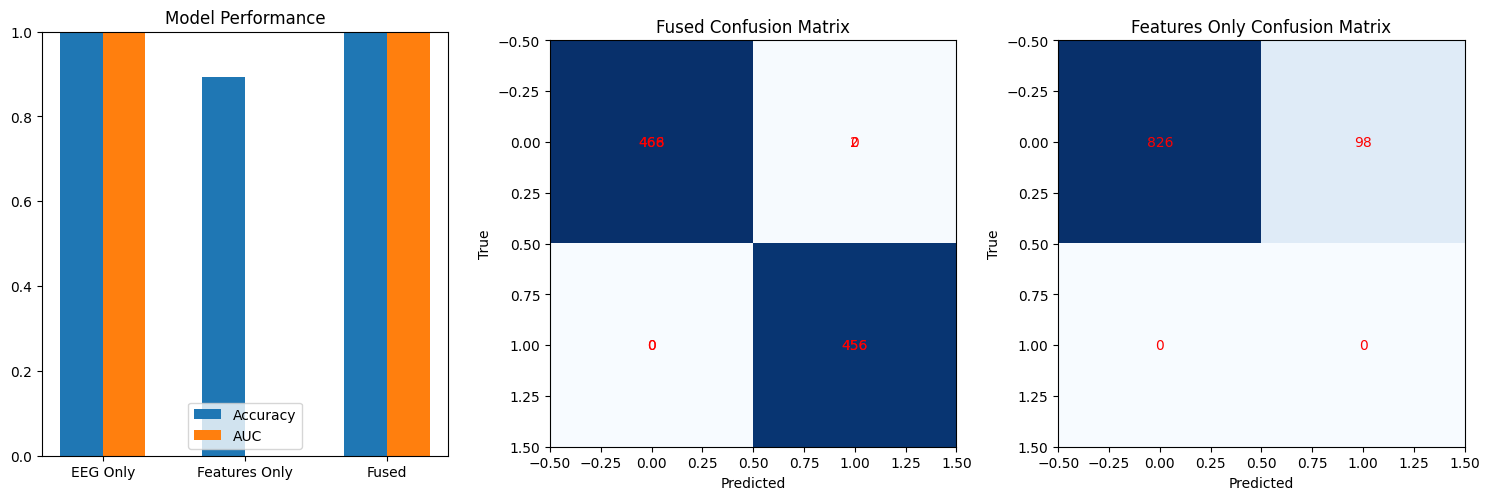

In [20]:
results = compare_models(
    models_and_datasets=[
        ("models/signal_only_model.pt", EEGDataset(X_seq, y_seq), False),
        ("models/features_only_model.pt", FeatureDataset(features_X, features_y), False),
        ("models/fused_model.pt", EEGWithFeaturesDataset(X_seq, features_X, y_seq), True)
    ],
    labels=["EEG Only", "Features Only", "Fused"],
    device=device
)

plot_comparison(results)
